# **Point Scanning Super Resolution (PSSR) - Training**

# **Preparation**
---

## **Set the Runtime Type**
---

<font size = 4>Go to **Runtime -> Change the Runtime type**

<font size = 4>**Runtime type: Python 3** *(Python 3 is programming language in which this program is written)*

<font size = 4>**Accelator: GPU** *(Graphics processing unit (GPU)*

In [1]:
#Run this cell to check if you have GPU access

import tensorflow as tf
if tf.test.gpu_device_name()=='':
  print('You do not have GPU access.') 
  print('Did you change your runtime ?') 
  print('If the runtime settings are correct then Google did not allocate GPU to your session')
  print('Expect slow performance. To access GPU try reconnecting later')
else:
  print('You have GPU access')

from tensorflow.python.client import device_lib 
device_lib.list_local_devices()

2023-05-12 19:29:41.146781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


You do not have GPU access.
Did you change your runtime ?
If the runtime settings are correct then Google did not allocate GPU to your session
Expect slow performance. To access GPU try reconnecting later


2023-05-12 19:29:42.631435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17445216500103990918
 xla_global_id: -1]

## Check GPU

In [1]:
from pynvml import *
nvmlInit()
handle = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(handle)
print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)

Total memory: 25769803776
Free memory: 24867700736
Used memory: 902103040


In [2]:
from pynvml import *
nvmlInit()
try:
    deviceCount = nvmlDeviceGetCount()
    for i in range(deviceCount):
        handle = nvmlDeviceGetHandleByIndex(i)
        print("Device", i, ":", nvmlDeviceGetName(handle))
except NVMLError as error:
    print(error)

Device 0 : b'NVIDIA TITAN RTX'


In [2]:
import nvidia_smi

nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
# card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

res = nvidia_smi.nvmlDeviceGetUtilizationRates(handle)
print(f'gpu: {res.gpu}%, gpu-mem: {res.memory}%')

gpu: 13%, gpu-mem: 7%


In [1]:
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

GPU RAM Free: 23725MB | Used: 483MB | Util   2% | Total 24576MB


## **Specify Your Working Folder - need your input**
---

In [2]:
root_path = "."

## **Install PSSR and Dependencies**
---

In [2]:
root_path = "."

import sys
import torch
sys.path.insert(1, root_path)
from utils import *
from fastai import *
from fastai.vision import *
from fastcore.script import *
from pathlib import Path
from fastprogress import master_bar, progress_bar
from time import sleep
import shutil
import PIL
import czifile
PIL.Image.MAX_IMAGE_PIXELS = 99999999999999

import PIL.Image
import imageio

from fastai.callbacks import *
from fastai.distributed import *
from fastai.vision.models.unet import DynamicUnet
from fastai.vision.models import resnet18, resnet34, resnet50
from skimage.util import random_noise
from skimage import filters
from utils.resnet import *
from utils.utils import unet_image_from_tiles_blend

from utils.crappifiers import *
import torchvision
import glob
from PIL import Image
from skimage.transform import rescale
from scipy.ndimage.interpolation import zoom as npzoom

from pandas.core.arrays.interval import NA
from numpy import NaN

/tmp/ipykernel_111090/1635112640.py:35: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom as npzoom


In [3]:
if 'learn' in locals():
    del learn
    gc.collect()
    torch.cuda.empty_cache()

torch.backends.cudnn.benchmark = True
print(torch.cuda.device(0))

## Helper Functions

In [2]:
def normalize(arr,negative=False):
    dtype = arr.dtype
    arr = arr.astype(np.float32)
    og_min, og_max = float(arr.min()), float(arr.max())
    # og_min, og_max = -212., 2047.
    # og_min, og_max = 33.315, 1258.7339
    if arr.dtype in (np.uint32, np.uint16, np.uint8):
        return (arr - og_min) / (og_max - og_min)
    else:
        return ((arr - og_min) / (og_max - og_min) - 0.5) * 2

# assumes data is properly normalized
def denormalize(data, dtype = np.int32):
    unsigned = (np.uint32, np.uint16, np.uint8)
    signed = (np.int32, np.int16, np.int8)
    if data.dtype in unsigned or (data.dtype in unsigned and data.min() < 0 or data.max() > 1) or (data.dtype in signed and data.min() < -1 or data.max() > 1):
        raise Exception('Unsupported data type. Input should be normalized')
    
    if dtype in (np.int32, np.int16, np.int8, np.uint32, np.uint16, np.uint8):
        return (data*np.iinfo(dtype).max).astype(dtype)
    else:
        return (data*np.finfo(dtype).max).astype(dtype)

In [95]:
def gen_test_gradient(size=512,dtype=np.int32):
    out = np.ones((size,size),dtype=dtype)*np.iinfo(dtype).max
    for i in np.arange(size):
        for j in np.arange(size):
            out[i,j] = out[i,j] * (i+j)/(2.*(size-1))
    return out

0 2147483647


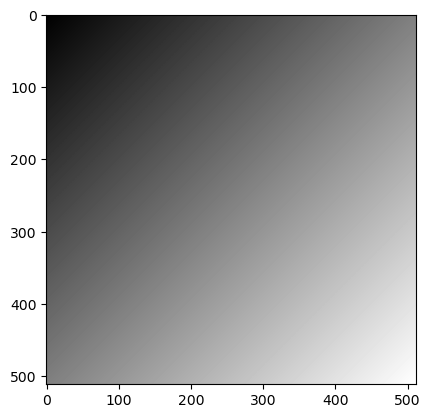

In [96]:
grad = gen_test_gradient()
print(grad.min(), grad.max())
plt.imshow(grad, cmap='gray')

In [85]:
test_img = Image.fromarray(grad)
test_img.save('test_grad.tif')

# **PSSR 01 - Get to Know Your Training Data**
---

## **Specify Your Datasource - need your input**
---

In [2]:
sources = [root_path + '/testGradient'] #must be in form of array
output_file = 'testGradient.csv'
only = 'sources'
skip = []

In [3]:
src_dirs = []
for src in sources:
    sub_fldrs = subfolders(Path(src))
    if skip: src_dirs += [fldr for fldr in sub_fldrs if fldr.stem not in skip]
    elif only: src_dirs += [fldr for fldr in sub_fldrs if fldr.stem in only]
    else: src_dirs += sub_fldrs

In [4]:
#@title process_czi()
def process_czi(item, category, mode):
#This function only takes the first channel of the czi files
#since those are the only mitotracker channels
    tif_srcs = []
    base_name = item.stem
    print('czi')
    with czifile.CziFile(item) as czi_f:
        data = czi_f.asarray()
        axes, shape = get_czi_shape_info(czi_f)
        channels = shape['C']
        depths = shape['Z']
        times = shape['T']
        #times = min(times, 30) #ONLY USE FIRST 30 frames
        x,y = shape['X'], shape['Y']

        mid_depth = depths // 2
        depth_range = range(max(0,mid_depth-2), min(depths, mid_depth+2))
        is_multi = (times > 1) or (depths > 1)

        data = czi_f.asarray()
        all_rmax = data.max()
        all_mi, all_ma = np.percentile(data, [2,99.99])

        dtype = data.dtype
        #for channel in range(channels): #if other channels are needed, use this line
        for channel in range(0,1):
            for z in depth_range:
                for t in range(times):
                    idx = build_index(
                        axes, {
                            'T': t,
                            'C': channel,
                            'Z': z,
                            'X': slice(0, x),
                            'Y': slice(0, y)
                        })
                    img = data[idx]
                    mi, ma = np.percentile(img, [2,99.99])
                    if dtype == np.uint8: rmax = 255.
                    else: rmax = img.max()
                    tif_srcs.append({'fn': item, 'ftype': 'czi', 'multi':int(is_multi), 'category': category, 'dsplit': mode,
                                     'uint8': dtype == np.uint8, 'mi': mi, 'ma': ma, 'rmax': rmax,
                                     'all_rmax': all_rmax, 'all_mi': all_mi, 'all_ma': all_ma,
                                     'mean': img.mean(), 'sd': img.std(),
                                     'nc': channels, 'nz': depths, 'nt': times,
                                     'z': z, 't': t, 'c':channel, 'x': x, 'y': y})
    return tif_srcs

In [5]:
def is_live(item):
    return item.parent.parts[-3] == 'live'

def process_tif(item, category, mode):
    mods = {
        'original': lambda x: x,
        # 'to_int32' : lambda x : denormalize(normalize(x))
        # 'normalized': lambda x : ((x - x.min()) / (x.max() - x.min()))
        # 'rot90': np.rot90,
        # 'rot180': lambda x: np.rot90(x, 2),
        # 'rot270': lambda x: np.rot90(x, 3),
        # 'hflip': np.fliplr,
        # 'vflip': np.flip,
        # 'zoom_tl': lambda x: np.repeat(np.repeat(x[:int(x.shape[0]/2), :int(x.shape[1]/2)], 2, 0), 2, 1),
        # 'zoom_tr': lambda x: np.repeat(np.repeat(x[:int(x.shape[0]/2), int(x.shape[1]/2):], 2, 0), 2, 1),
        # 'zoom_bl': lambda x: np.repeat(np.repeat(x[int(x.shape[0]/2):, :int(x.shape[1]/2)], 2, 0), 2, 1),
        # 'zoom_br': lambda x: np.repeat(np.repeat(x[int(x.shape[0]/2):, int(x.shape[1]/2):], 2, 0), 2, 1)
    }

    tif_srcs = []
    img = PIL.Image.open(item)
    n_frames = img.n_frames
    x,y = img.size
    is_multi = n_frames > 1
    #n_frames = min(n_frames, 30) #ONLY USE FIRST 30 frames

    data = []
    for n in range(n_frames):
        img.seek(n)
        img.load()
        img_data = np.array(img)

        data.append(img_data)

    data = np.stack(data)
    all_rmax = data.max().astype(np.int32)
    all_rmin = data.min().astype(np.int32)
    all_mi, all_ma = np.percentile(data, [2,99.99]).astype(np.float32)

    dir = sources[0] + f'/{category}_modded'
    if not os.path.isdir(dir):
        os.mkdir(dir)
    if not os.path.isdir(dir + f'/{mode}'):
        print(dir + f'/{mode}')
        os.mkdir(dir + f'/{mode}')

    for n in range(n_frames):
        img_data = data[n]
        dtype = img_data.dtype
        mi, ma = np.percentile(img_data, [2,99.99]).astype(np.float32)
        # if dtype == np.int32: rmax = np.iinfo(np.int32).max
        # else: rmax = img_data.max()
        rmax = img_data.max().astype(np.int32)
        rmin = img_data.min().astype(np.int32)
        if is_live(item):
            t, z = n, 0
            nt, nz = n_frames, 1
        else:
            t, z = 0, n
            nt, nz = 1, n_frames

        for mod in mods.keys():
            modname = str(item).split('/')[-1].split('.')
            modname[0], modname[-1] = modname[0] + f'_{mod}', '.' + modname[-1]
            modname = ''.join(modname)
            item_mod_name = f'{dir}/{mode}/{modname}'

            Image.fromarray(mods[mod](np.array(Image.open(item)))).save(item_mod_name)

            tif_srcs.append({'fn': item_mod_name, 'ftype': 'tif', 'multi':int(is_multi), 'category': category, 'dsplit': mode,
                            'int32': dtype==np.int32, 'mi': mi, 'ma': ma, 'rmin': rmin, 'rmax': rmax,
                            'all_rmin': all_rmin, 'all_rmax': all_rmax, 'all_mi': all_mi, 'all_ma': all_ma,
                            'mean': img_data.mean(), 'sd': img_data.std(),
                            'nc': 1, 'nz': nz, 'nt': nt,
                            'z': z, 't': t, 'c':0, 'x': x, 'y': y})
    return tif_srcs

def process_unk(item, category, mode):
    print(f"**** Unknown: {item}")
    return []

def process_item(item, category, mode):
    try:
        if mode == 'test': return []
        else:
            item_map = {
                '.tif': process_tif,
                '.tiff': process_tif,
                '.czi': process_czi,
            }
            map_f = item_map.get(item.suffix, process_unk)
            return map_f(item, category, mode)
    except Exception as ex:
        print(f'err procesing: {item}')
        print(ex)
        return []

def build_tifs(src, mbar=None):
    tif_srcs = []
    for mode in ['train', 'valid', 'test']:
        live = src.parent.parts[-1] == 'live'
        src_dir = src / mode
        category = src.stem
        items = list(src_dir.iterdir()) if src_dir.exists() else []
        if items:
            for p in progress_bar(items, parent=mbar):
                mbar.child.comment = mode
                tif_srcs += process_item(p, category=category, mode=mode)
    return tif_srcs

In [6]:
#pull metadata from datasources
mbar = master_bar(src_dirs)
tif_srcs = []
for src in mbar:
    mbar.write(f'process {src.stem}')
    tif_srcs += build_tifs(src, mbar=mbar)

In [7]:
#save csv to disk
tif_src_df = pd.DataFrame(tif_srcs)
tif_src_df[['category','dsplit','multi','ftype','int32','mean','sd','all_rmin','all_rmax','all_mi','all_ma','mi','ma','rmin','rmax','nc','nz','nt','c','z','t','x','y','fn']].to_csv(output_file, header=True, index=False)
shutil.move(output_file, f'{root_path}/{output_file}')


'./testGradient.csv'

# **PSSR 02 - Generate Training Datasets**
---

In [12]:
from pandas._libs.lib import tuples_to_object_array
def need_cache_flush(tile_stats, last_stats):
    if last_stats is None: return True
    if tile_stats['fn'] != last_stats['fn']: return True
    return False

def get_tile_puller(tile_stat, crap_func, t_frames, z_frames):

    def normalize(arr,negative=False):
        dtype = arr.dtype
        arr = arr.astype(np.float32)
        og_min, og_max = float(arr.min()), float(arr.max())
        # og_min, og_max = -212., 2047.
        # og_min, og_max = 33.315, 1258.7339
        if arr.dtype in (np.uint32, np.uint16, np.uint8):
            return (arr - og_min) / (og_max - og_min)
        else:
            return ((arr - og_min) / (og_max - og_min) - 0.5) * 2

    # assumes data is properly normalized
    def denormalize(data, dtype = np.int32):
        unsigned = (np.uint32, np.uint16, np.uint8)
        signed = (np.int32, np.int16, np.int8)
        if data.dtype in unsigned or (data.dtype in unsigned and data.min() < 0 or data.max() > 1) or (data.dtype in signed and data.min() < -1 or data.max() > 1):
            raise Exception('Unsupported data type. Input should be normalized')
        
        if dtype in (np.int32, np.int16, np.int8, np.uint32, np.uint16, np.uint8):
            return (data*np.iinfo(dtype).max).astype(dtype)
        else:
            return (data*np.finfo(dtype).max).astype(dtype)

    fn = tile_stat['fn']
    ftype = tile_stat['ftype']
    nz = tile_stat['nz']
    nt = tile_stat['nt']

    half_z = z_frames // 2
    half_t = t_frames // 2

    if ftype == 'czi':
        img_f = czifile.CziFile(fn)
        proc_axes, proc_shape = get_czi_shape_info(img_f)
        img_data = img_f.asarray()
        img_data = img_data.astype(np.int32)

        def czi_get(istat):
            c,z,t,x,y,mi,ma,is_uint8,rmax,all_rmax,all_ma = [istat[fld] for fld in ['c','z','t','x','y','mi','ma','uint8','rmax','all_rmax','all_ma']]
            if is_uint8:
                mi, ma, rmax = 0., 255.0, 255.0
                all_ma, all_rmax = 255.0, 255.0

            t_slice = slice(t-half_t, t+half_t+1) if half_t > 0 else t
            z_slice = slice(z-half_z, z+half_z+1) if half_z > 0 else z
            idx = build_index(
                proc_axes, {
                    'C': c,
                    'T': t_slice,
                    'Z': z_slice,
                    'X': slice(0, x),
                    'Y': slice(0, y)
                })
            img = img_data[idx].copy()
            img /= all_rmax
            if len(img.shape) <= 2: img = img[None]
            return img

        img_get = czi_get
        img_get._to_close = img_f
    else:
        pil_img = PIL.Image.open(fn)
        def pil_get(istat):
            c,z,t,x,y,mi,ma,is_int32,rmax,all_rmax,all_ma = [istat[fld] for fld in ['c','z','t','x','y','mi','ma','int32','rmax','all_rmax','all_ma']]
            if half_t > 0: n_start, n_end = t-half_t, t+half_t+1
            elif half_z > 0: n_start, n_end = z-half_z, z+half_z+1
            else: n_start, n_end = 0,1

            # if is_int32:
            #     low, high = np.finfo(np.float32).min, np.finfo(np.float32).max
            #     mi, ma, rmax = low, high, high
            #     all_ma, all_rmax = high, high

            img_array = []
            img_max = 0
            for ix in range(n_start, n_end):
                pil_img.seek(ix)
                pil_img.load()
                img = np.array(pil_img).astype(np.float32)
                # img_min, img_max = img.min(), img.max
                # img = (((img + 212.) / 2259.) * np.iinfo(np.uint8).max).astype(np.uint8)

                if len(img.shape) > 2: img = img[:,:,0]
                img_array.append(img.copy())
                
                # img_max = max(img_max, img.max())

            img = np.stack(img_array)

            # img = img
            # img /= img_max
            return img

        img_get = pil_get
        img_get._to_close = pil_img


    def puller(istat, tile_folder, crap_folder, close_me=False):
        if close_me:
            img_get._to_close.close()
            return None

        id = istat['index']
        fn = Path(istat['fn'])
        tile_sz = istat['tile_sz']
        c,z,t,x,y,mi,ma,is_int32,rmin,rmax,mean = [istat[fld] for fld in ['c','z','t','x','y','mi','ma','int32','rmin','rmax','mean']]

        # raw_data = img_get(istat)
        raw_data = img_get(istat)
        img_data = denormalize(normalize(raw_data))
        # img_data = (raw_data * rmax).astype(np.int32)

        thresh = np.percentile(img_data, 2)
        thresh_pct = (img_data > thresh).mean() * 0.30

        frame_count = img_data.shape[0]
        mid_frame = frame_count // 2
        crop_img, box = draw_random_tile(img_data[mid_frame], istat['tile_sz'], thresh, thresh_pct)
        crop_img.save(tile_folder/f'{id:06d}_{fn.stem}.tif')
        
        if crap_func and crap_folder:
            if frame_count > 1:
                crap_data = []
                for i in range(frame_count):
                    frame_img = img_data[i, box[0]:box[2], box[1]:box[3]]
                    crap_frame = crap_func(frame_img)
                    crap_data.append(np.array(crap_frame))
                multi_array = np.stack(crap_data)
                np.save(crap_folder/f'{id:06d}_{fn.stem}.npy', multi_array)
            else:
                crap_img = crap_func(crop_img)
                crap_img.save(crap_folder/f'{id:06d}_{fn.stem}.tif')

        info = dict(istat)
        info['id'] = id
        info['box'] = box
        info['tile_sz'] = tile_sz
        crop_data = np.array(crop_img)
        info['after_mean'] = crop_data.mean()
        info['after_sd'] = crop_data.std()
        info['after_max'] = crop_data.max()
        info['after_min'] = crop_data.min()
        return info

    return puller

def check_info(info, t_frames, z_frames):
    t_space = t_frames // 2
    z_space = z_frames // 2

    z_ok = (info['nz'] >= z_frames) and (info['z'] >= z_space) and (info['z'] < (info['nz']-z_space))
    t_ok = (info['nt'] >= t_frames) and (info['t'] >= t_space) and (info['t'] < (info['nt']-t_space))

    return t_ok and z_ok

## **Specify Your Datasource - need your input**
---

In [13]:
out = Path(root_path) #dataset folder, Path
info = Path(root_path + '/testGradient.csv') #path of the metadata csv file, Path
tile = 512 #generated training tile size, int
n_train: int = 5 #number of train tiles, int
n_valid: int = 1 #number of validation tiles', int
crap_func = 'zero_crap' #crappifier name, str, check utils/crappifiers.py for more details
n_frames = 1 #number of frames, int, 1 if singleframe, >1 if multiframe, 5 for multiframe by default
lr_type = 's' # (s)ingle, (t) multi or (z) multi', string, if multiframe, t if XYT time-lapse, z if XYZ 3D stack
scale = 1 # upsample factor, int (scales tile)
upsample = False # if LR-Bilinear is needed to save to disk, boolean

In [14]:
up = 'up' if upsample else ''
if lr_type not in ['s','t test = (test - test.min()) / (test.max() - test.min())','z']:
    print('lr_type should be s, t or z')
    # return 1

if lr_type == 's':
    z_frames, t_frames = 1, 1
elif lr_type == 't':
    z_frames, t_frames = 1, n_frames
elif lr_type == 'z':
    z_frames, t_frames = n_frames, 1

out = ensure_folder(out/f'{lr_type}_{n_frames}_{info.stem}_{crap_func}')
if out.exists(): shutil.rmtree(out)
out.mkdir(parents=True, mode=0o775, exist_ok=True)

crap_func = eval(crap_func)
if not crap_func is None:
    if not callable(crap_func):
        print('crap_func is not callable')
        crap_func = None
    else:
        crap_func = partial(crap_func, scale=scale, upsample=upsample)

info = pd.read_csv(info)
info = info.loc[info.nz >= z_frames]
info = info.loc[info.nt >= t_frames]

In [15]:
tile_infos = []
for mode, n_samples in [('train', n_train),('valid', n_valid)]:
    mode_info = info.loc[info.dsplit == mode]
    categories = list(mode_info.groupby('category'))
    files_by_category  = {c:list(info.groupby('fn')) for c,info in categories}

    for i in range(n_samples):
        category, cat_df = random.choice(categories)
        fn, item_df = random.choice(files_by_category[category])
        legal_choices = [item_info for ix, item_info in item_df.iterrows() if check_info(item_info, t_frames, z_frames)]

        assert(legal_choices)
        item_info = random.choice(legal_choices)
        for tile_sz in [tile]:
            item_d = dict(item_info)
            item_d['tile_sz'] = tile_sz
            tile_infos.append(item_d)

tile_info_df = pd.DataFrame(tile_infos).reset_index()
print('num tile pulls:', len(tile_infos))
print(tile_info_df.groupby('category').fn.count())

num tile pulls: 6
category
sources    6
Name: fn, dtype: int64


In [16]:
last_stat = None
tile_pull_info = []
tile_puller = None

multi_str = f'_{lr_type}_{n_frames}' if lr_type != 's' else ''
mbar = master_bar(tile_info_df.groupby('fn'))
for fn, tile_stats in mbar:
    for i, tile_stat in progress_bar(list(tile_stats.iterrows()), parent=mbar):
        try:
            mode = tile_stat['dsplit']
            category = tile_stat['category']
            tile_sz = tile_stat['tile_sz']
            tile_folder = ensure_folder(out / f'hr_t_{tile_sz}{multi_str}' / mode / category)
            if crap_func:
                crap_folder = ensure_folder(out / f'lr{up}_t_{tile_sz}{multi_str}' / mode / category)
            else: crap_folder = None

            if need_cache_flush(tile_stat, last_stat):
                if tile_puller:
                    tile_puller(None, None, None, close_me=True)
                last_stat = tile_stat.copy()
                tile_sz = tile_stat['tile_sz']
                tile_puller = get_tile_puller(tile_stat, crap_func, t_frames, z_frames)
            tile_pull_info.append(tile_puller(tile_stat, tile_folder, crap_folder))
        except MemoryError as error:
            # some files are too big to read
            fn = Path(tile_stat['fn'])
            print(f'too big: {fn.stem}')

pd.DataFrame(tile_pull_info).to_csv(out/f'tiles{multi_str}.csv', index = False)

# **PSSR 03 - Train Your Data**
---

## **Hyper-Parameter Configuration - need your input**
---

In [16]:
#basic adjustable hyper-parameters - configure as needed
datasetname = 's_1_testGradient_zero_crap'
tile_sz = 512 # size of original input tile
n_frames = 1
lr_type = 's' #'s' or 't' or 'z'
bs = 3
size = 512 # size of output tile
# lr = 4e-4
l_rate = 2e-3
cycles = 10

In [17]:
#advanced adjustable hyper-parameters - keep default numbers in most cases

#data augmentation related
cutout = False
norm = True
# mode = 'L'
mode = 'I'

#network architecture
arch_name = 'wnresnet34'
attn = True
blur = True
final_blur = True
bottle = True
last_cross = True

#fitting related
l1_loss = False
lr_start = None
load_name = None
freeze = False
wd = 1e-3
save_name = None

## **Prepare Databunch**
---

In [18]:
def get_src(x_data, y_data, n_frames=1, mode='I'):
    def map_to_hr(x):
        return y_data/x.relative_to(x_data).with_suffix('.tif')

    if n_frames == 1:
        src = (ImageImageList
                .from_folder(x_data, convert_mode=mode)
                .split_by_folder()
                .label_from_func(map_to_hr, convert_mode=mode))
    else:
        src = (MultiImageImageList
                .from_folder(x_data, extensions=['.npy'])
                .split_by_folder()
                .label_from_func(map_to_hr, convert_mode=mode))
    return src

def get_data(bs, size, x_data, y_data,
             n_frames=1,
             max_rotate=10.,
             min_zoom=1., max_zoom=1.1,
             use_cutout=False,
             use_noise=False,
             scale=4,
             xtra_tfms=None,
             gauss_sigma=(0.4,0.7),
             pscale=(5,30),
             mode='L',
             norm=False,
             **kwargs):
    src = get_src(x_data, y_data, n_frames=n_frames, mode=mode)

    x_tfms, y_tfms = get_xy_transforms(
                          max_rotate=max_rotate,
                          min_zoom=min_zoom, max_zoom=max_zoom,
                          use_cutout=use_cutout,
                          use_noise=use_noise,
                          gauss_sigma=gauss_sigma,
                          pscale=pscale,
                          xtra_tfms = xtra_tfms)
    x_size = size // scale
    data = (src
            .transform(x_tfms, size=x_size)
            .transform_y(y_tfms, size=size)
            .databunch(bs=bs, **kwargs))
    
    if norm:
        print('normalizing x and y data')
        data = data.normalize(do_y=True)
        test = np.array(Image.open(data.items[0]))
        plt.imshow(test, cmap="gray")
        print(test[500:,500:])
    #data.c = 3 #why?
    return data

normalizing x and y data
[[2055028479 2059230975 2063433471 2067635967 ... 2088648447 2092850943 2097053439 2101255935]
 [2059230975 2063433471 2067635967 2071838463 ... 2092850943 2097053439 2101255935 2105458431]
 [2063433471 2067635967 2071838463 2076040959 ... 2097053439 2101255935 2105458431 2109660927]
 [2067635967 2071838463 2076040959 2080243455 ... 2101255935 2105458431 2109660927 2113863423]
 ...
 [2088648447 2092850943 2097053439 2101255935 ... 2122268671 2126471167 2130673663 2134876159]
 [2092850943 2097053439 2101255935 2105458431 ... 2126471167 2130673663 2134876159 2139078655]
 [2097053439 2101255935 2105458431 2109660927 ... 2130673663 2134876159 2139078655 2143281151]
 [2101255935 2105458431 2109660927 2113863423 ... 2134876159 2139078655 2143281151 2147483647]]
bs: 3 size:  512


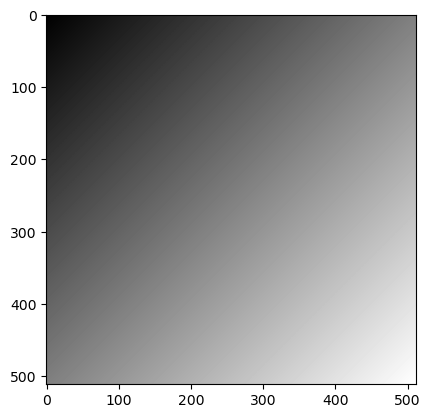

In [19]:
datasets = Path(root_path)
dataset = datasets/datasetname
if tile_sz is None:
    hr_tifs = dataset/f'hr'
    lr_tifs = dataset/f'lr'
else:
    multi_str = f'_{lr_type}_{n_frames}' if lr_type != 's' else ''
    hr_tifs = dataset/f'hr_t_{tile_sz:d}{multi_str}'
    lr_tifs = dataset/f'lr_t_{tile_sz:d}{multi_str}'

data = get_data(bs, size, lr_tifs, hr_tifs, n_frames=n_frames, max_zoom=4.,
                use_cutout=cutout, mode=mode, norm=norm)
print('bs:', bs, 'size: ', size)

## **Set Up Learner**
--- 

In [20]:
# Set up the learner
if save_name is None: 
    save_name = f'{datasetname}_{cycles}epochs'
pickle_models = Path(root_path)/'stats/models'
pth_models = Path(root_path)/'models'
if l1_loss: loss = F.l1_loss
else: loss = F.mse_loss
print('loss: ', loss)

callback_fns = []
callback_fns.append(partial(SaveModelCallback, name=f'{save_name}_best_{size}'))

wnres_args = {
    'blur': blur,
    'blur_final': final_blur,
    'bottle': bottle,
    'self_attention': attn,
    'last_cross': True
}
arch = eval(arch_name)
learn = wnres_unet_learner(data, arch, in_c=n_frames, wnres_args=wnres_args,
                          path=Path('.'), loss_func=loss, metrics=sr_metrics,
                          model_dir=pth_models, callback_fns=callback_fns, wd=wd, bilinear_upsample=True)
learn.to_fp32()

if load_name:
    learn = learn.load(f'{load_name}')
    print(f'loaded {load_name}')

if freeze: learn.freeze()

if not lr_start is None: lr = slice(lr_start, l_rate)
else: lr = slice(None, l_rate, None)

loss:  <function mse_loss at 0x7f25f4797910>


## **Train & Export**
___

In [21]:
learn.fit_one_cycle(cycles, lr)
learn.save(save_name)
print(f'saved: {save_name}')
learn.export(pickle_models/f'{save_name}_{size}.pkl')
print('exported')

# learn.recorder.plot()

Better model found at epoch 0 with valid_loss value: 1.6302993297576904.
Better model found at epoch 1 with valid_loss value: 1.4954454898834229.
Better model found at epoch 2 with valid_loss value: 1.211216688156128.
Better model found at epoch 5 with valid_loss value: 1.2006149291992188.
Better model found at epoch 6 with valid_loss value: 1.1253529787063599.
Better model found at epoch 7 with valid_loss value: 1.0602871179580688.
Better model found at epoch 8 with valid_loss value: 1.023527979850769.
Better model found at epoch 9 with valid_loss value: 1.0112487077713013.
saved: s_1_testGradient_zero_crap_10epochs
exported


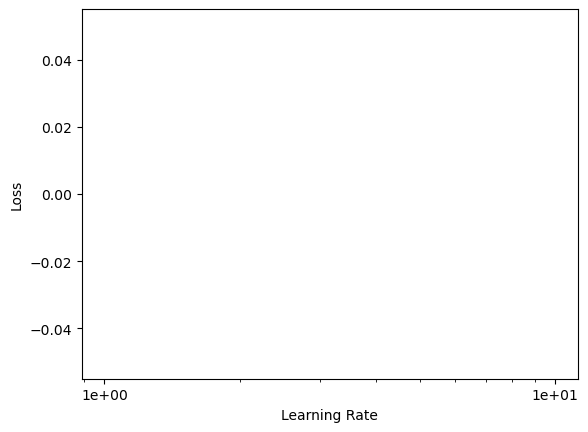

In [22]:
learn.recorder.plot()

## **Export Trained PSSR Model**

# **PSSR 04 - Inference**
---

## **Specify Your Model and Test Data - need your input**
---

In [23]:
# Modify accordingly
model_name = 's_1_testGradient_zero_crap_10epochs_512'
testset_name = 'testGradient'
use_tiles = True
mode = 'I' #Param("L or RGBA", str)

## **Prepare for Inference**
---

In [24]:
# Prepare model
test_path = Path(root_path)/'stats'
model_name = model_name
model_dir = test_path/'models'
print(f'{model_name} model is being used.')

# Prepare data
testset_name = testset_name
src_dir = test_path/'LR'/testset_name
out_dir = test_path/'LR-PSSR'/testset_name
out_dir = ensure_folder(out_dir)

s_1_testGradient_zero_crap_10epochs_512 model is being used.


## **Inference**
---

In [25]:
#@title process_czi

def process_czi(fn, processor, proc_func, out_fn, n_depth=1, n_time=1, mode='L'):
    stats = []
    with czifile.CziFile(fn) as czi_f:
        proc_axes, proc_shape = get_czi_shape_info(czi_f)
        channels = proc_shape['C']
        depths = proc_shape['Z']
        times = proc_shape['T']
        x, y = proc_shape['X'], proc_shape['Y']

        data = czi_f.asarray().astype(np.float32)
        data, img_info = img_to_float(data)

        if depths < n_depth: return
        if times < n_time: return

        if n_depth > 1: # this is busted
            offset_frames = n_depth // 2
            for c in range(channels):
                for t in range(times):
                    for z in range(offset_frames, depths - offset_frame):
                        depth_slice = slice(z-offset_frames, z+offset_frame+1)
                        idx = build_index(
                            proc_axes, {
                                'T': t,
                                'C': c,
                                'Z': depth_slice,
                                'X': slice(0, x),
                                'Y': slice(0, y)
                        })
                        img = data[idx].copy()
                        tag = f'{c}_{t}_{z+offset_frames}_'

                        save_name = f'{proc_name}_{item.stem}_{tag}'

                        pred_img = proc_func(img, img_info=img_info, mode=mode)
                        pred_img8 = (pred_img * np.iinfo(np.uint8).max).astype(np.uint8)
                        PIL.Image.fromarray(pred_img8).save(out_fn)
        elif n_time > 1:
            offset_frames = n_time // 2
            for c in range(channels):
                for z in range(depths):
                    imgs = []
                    time_range = list(range(offset_frames, times - offset_frames))
                    for t in progress_bar(time_range):
                        time_slice = slice(t-offset_frames, t+offset_frames+1)
                        idx = build_index(
                            proc_axes, {
                                'T': time_slice,
                                'C': c,
                                'Z': z,
                                'X': slice(0, x),
                                'Y': slice(0, y)
                        })
                        img = data[idx].copy()
                        pred_img = proc_func(img, img_info=img_info, mode=mode)
                        pred_img8 = (pred_img * np.iinfo(np.uint8).max).astype(np.uint8)
                        imgs.append(pred_img8[None])

                    all_y = np.concatenate(imgs)
                    if processor!='bilinear':
                        fldr_name = f'{out_fn.parent}/{processor}'
                    else:
                        fldr_name = out_fn.parent.parent.parent/processor/out_fn.parent.stem
                    save_name = f'{fn.stem}_{processor}.tif'
                    if c > 1 or z > 1:
                        fldr_name = fldr_name/f'{c}_{z}'
                    out_fldr = ensure_folder(fldr_name)

                    if all_y.size < 4e9:
                        imageio.mimwrite(out_fldr/save_name, all_y)
                    else:
                        imageio.mimwrite(out_fldr/save_name, all_y, bigtiff=True)
        else:
            imgs = []
            for c in range(channels):
                for z in range(depths):
                    for t in range(times):
                        idx = build_index(
                            proc_axes, {
                                'T': t,
                                'C': c,
                                'Z': z,
                                'X': slice(0, x),
                                'Y': slice(0, y)
                        })
                        img = data[idx].copy()
                        pred_img = proc_func(img, img_info=img_info, mode=mode)
                        pred_img8 = (pred_img * np.iinfo(np.uint8).max).astype(np.uint8)
                        imgs.append(pred_img8[None])
            all_y = np.concatenate(imgs)
            if processor!='bilinear':
                fldr_name = f'{out_fn.parent}/{processor}'
            else:
                fldr_name = out_fn.parent.parent.parent/processor/out_fn.parent.stem
            save_name = f'{fn.stem}_{processor}.tif'
            out_fldr = ensure_folder(fldr_name)

            if all_y.size < 4e9:
                imageio.mimwrite(out_fldr/save_name, all_y)
            else:
                imageio.mimwrite(out_fldr/save_name, all_y, bigtiff=True)

In [61]:
def process_tif(fn, processor, proc_func, out_fn, n_depth=1, n_time=1, mode='I'):
    with PIL.Image.open(fn) as img_tif:
        n_frame = max(n_depth, n_time)
        offset_frames = n_frame // 2

        if n_frame > img_tif.n_frames:
            if img_tif.n_frames == 1:
                times = n_frame
                img_tif = np.array(img_tif)
                data = np.repeat(img_tif[None],5,axis=0).astype(np.int32)
            else:
                return []
        else:
            times = img_tif.n_frames
            img_tifs = []
            for i in range(times):
                img_tif.seek(i)
                img_tif.load()
                img_tifs.append(np.array(img_tif).copy())
            data = np.stack(img_tifs).astype(np.int32)

        data, img_info = img_to_float(data)
        img_tiffs = []
        time_range = list(range(offset_frames, times - offset_frames))
        for t in progress_bar(time_range):
            time_slice = slice(t-offset_frames, t+offset_frames+1)
            img = data[time_slice].copy().astype(np.int64)
            img = img[0]
            pred_img = proc_func(img, img_info=img_info, mode=mode)
            print(pred_img)
            pred_img32 = pred_img
            # pred_img32 = (pred_img * np.iinfo(np.int32).max).astype(np.int32)
            img_tiffs.append(pred_img32[None])

        # imgs = np.concatenate(img_tiffs)
        if processor!='bilinear':
            fldr_name = f'{out_fn.parent}/{processor}'
        else:
            fldr_name = out_fn.parent.parent.parent/processor/out_fn.parent.stem
        save_name = f'{fn.stem}_{processor}.tif'
        out_fldr = ensure_folder(out_fn.parent/processor)

        # if imgs.size < 4e9:
        #     imageio.mimwrite(out_fldr/save_name, imgs)
        # else:
        #     imageio.mimwrite(out_fldr/save_name, imgs, bigtiff=True)

def process_files(src_dir, out_dir, model_dir, processor, mode, use_tiles):
    proc_map = {
        '.tif': process_tif,
        '.czi': process_czi
    }

    proc_func, num_chan = get_named_processor(processor, model_dir, use_tiles)
    src_files = list(src_dir.glob('**/*.czi'))
    src_files += list(src_dir.glob('**/*.tif'))

    for fn in progress_bar(src_files):
        out_fn = out_dir/fn.relative_to(src_dir)
        ensure_folder(out_fn.parent)
        file_proc = proc_map.get(fn.suffix, None)
        if file_proc:
            n_depth = n_time = 1
            if 'z_' in processor: n_depth = num_chan
            if 't_' in processor: n_time = num_chan
            print('File being processed: ', fn)
            file_proc(fn, processor, proc_func, out_fn, n_depth=n_depth, n_time=n_time, mode=mode)

In [62]:
process_files(src_dir, out_dir, model_dir, model_name, mode, use_tiles)
print('All done!')

/home/gigo/anaconda3/envs/pssrMichael/lib/python3.10/site-packages/fastai/torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


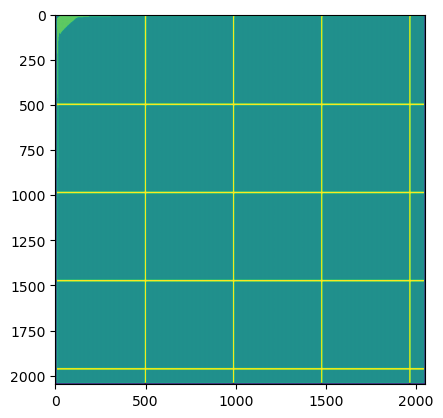

In [67]:
out_path = '/home/gigo/pssr_Michael/stats/LR-PSSR/testGradient/s_1_testGradient_zero_crap_10epochs_512/test_grad_s_1_testGradient_zero_crap_10epochs_512.tif'
out_img = Image.open(out_path)
inferred = np.array(out_img)
out_img.save("out_img.tif")
plt.imshow(inferred)